Graphs and Charts
========================
This notebook looks at some of the tools for building graphical visualizations of our data, as well as some new, useful techniques for transforming data to help with the data viz.

Topics covered:

- `DataFrame.melt()` the "unpivot" method that helps transform data from "wide" to "long" format
- `DataFrame.drop_duplicates()` to remove duplicate rows
- calculating correlations on all factors
- heatmap table of correlations
- using `zscore` to drop outliers
- controlling size, color, other attributes of `matplotlib` images
- simple bar charts
- grouped bar charts
- scatter plots
- network (node/edge) diagrams
- our custom helper functions, `ui.fmt_table()`
- new `school_data` package for custom code

The data for these examples comes from the combined demographic and grades 3-8 ELA test score data set.

In [1]:
# automatically reload changes we make to schools.py and ui.py
%load_ext autoreload
%autoreload 2

# load the demographic data
import pandas as pd

import numpy as np
import scipy as scipy
from scipy.stats import pearsonr
import statsmodels.api as sm
import pingouin as pg
from statsmodels.formula.api import ols


# graphs and viz
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


import math

from IPython.display import Markdown as md

from school_data import schools, ui


In [2]:
# load the demographic data and merge it with the ELA data
df = schools.load_school_demographics()

# load the data from the csv file
ela = pd.read_csv("ela-combined.csv")


#drop the rows with NaN (where the pop is too small to report)
ela = ela[ela["mean_scale_score"].notnull()]
ela = df.merge(ela, how="inner", on=["dbn", "year"])

In [3]:
df[schools.demo.core_cols]

,dbn,district,boro,school_name,year,total_enrollment,asian_n,asian_pct,black_n,black_pct,...,hispanic_pct,white_n,white_pct,swd_n,swd_pct,ell_n,ell_pct,poverty_n,poverty_pct,eni_pct
0,01M015,1,Manhattan,P.S. 015 Roberto Clemente,2016,178,14,0.079000,51,0.287000,...,0.590000,4,0.022000,51,0.287000,12,0.067,152,0.854,0.882
1,01M015,1,Manhattan,P.S. 015 Roberto Clemente,2017,190,20,0.105000,52,0.274000,...,0.579000,6,0.032000,49,0.258000,8,0.042,161,0.847,0.890
2,01M015,1,Manhattan,P.S. 015 Roberto Clemente,2018,174,24,0.138000,48,0.276000,...,0.546000,6,0.034000,39,0.224000,8,0.046,147,0.845,0.888
3,01M015,1,Manhattan,P.S. 015 Roberto Clemente,2019,190,27,0.142000,56,0.295000,...,0.505000,9,0.047000,46,0.242000,17,0.089,155,0.816,0.867
4,01M015,1,Manhattan,P.S. 015 Roberto Clemente,2020,193,26,0.135000,53,0.275000,...,0.528000,11,0.057000,43,0.223000,21,0.109,158,0.819,0.856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9164,84X730,84,Bronx,Bronx Charter School for the Arts,2016,320,2,0.006250,76,0.237500,...,0.737500,3,0.009375,67,0.209375,51,0.159,235,0.734,0.840
9165,84X730,84,Bronx,Bronx Charter School for the Arts,2017,314,2,0.006369,65,0.207006,...,0.773885,1,0.003185,68,0.216561,57,0.182,258,0.822,0.891
9166,84X730,84,Bronx,Bronx Charter School for the Arts,2018,430,2,0.004651,98,0.227907,...,0.746512,3,0.006977,103,0.239535,71,0.165,363,0.844,0.888
9167,84X730,84,Bronx,Bronx Charter School for the Arts,2019,523,1,0.001912,131,0.250478,...,0.722753,5,0.009560,117,0.223709,69,0.132,453,0.866,0.892


Simple Bar Chart: Citywide student demographics
------------------------------------------------------------------------
Drawing from the counts of students in different
demographic categories (`asian_n`, `ell_n`) we will draw a basic bar chart.

### `melt()` to un-pivot data
The first thing we do is **melt** the columns with the demographic counts
into a single column. Typically, a melt will create two new columns:
one with the categories or `id` labels for the row, and a second with
the `values` for the row. In this example we create **enroll_cat** (`id`)
to tell us which _category_ of enrollment number we're looking at
and **enrollment** (`values`) to hold the number of students for that row for
that category. Each row in this dataframe reports the observation
for a specicif school, grade, academic year (`dbn`, `grade`, `year`).


In [4]:
# copy the df if so we don't modify it
totals = df.copy()

# work with just one year to make things clearer
totals = totals[totals["year"] == 2020]


# define the category columns -- the columns which will be "melted" / collapsed
cats = ["total_enrollment", "asian_n", "black_n","hispanic_n","white_n"]

# the columns that will be the same after the melt
id_cols = ["dbn", "district", "boro"]

# get just the cols we want from the df
totals = totals[id_cols + cats]

# make nice names for our columns by dropping the _n and renaming total_enrollment to "all students"
# these column headers will become the data in the enroll_cat column after the melt
cats = ["all students", "asian", "black", "hispanic","white"]
totals.columns = id_cols + cats

totals

,dbn,district,boro,all students,asian,black,hispanic,white
4,01M015,1,Manhattan,193,26,53,102,11
9,01M019,1,Manhattan,212,13,41,130,17
14,01M020,1,Manhattan,412,102,55,215,30
19,01M034,1,Manhattan,273,7,104,152,8
24,01M063,1,Manhattan,208,6,40,132,19
...,...,...,...,...,...,...,...,...
9148,84X705,84,Bronx,416,3,88,323,0
9153,84X706,84,Bronx,647,0,399,232,4
9158,84X717,84,Bronx,328,4,164,157,0
9163,84X718,84,Bronx,570,5,482,57,8


In [5]:
# melt tutorial:
# https://www.educba.com/pandas-melt/
data = pd.melt(totals, id_vars=id_cols, value_vars=cats, var_name="enroll_cat", value_name="enrollment")


# let's look at one grade for one school for one year (2019) to see what our data looks like
data.query("dbn == '01M015'")

,dbn,district,boro,enroll_cat,enrollment
0,01M015,1,Manhattan,all students,193
1878,01M015,1,Manhattan,asian,26
3756,01M015,1,Manhattan,black,53
5634,01M015,1,Manhattan,hispanic,102
7512,01M015,1,Manhattan,white,11


In [6]:
# use groupby and agg to get the city wide enrollment data
city_enroll = data[["enroll_cat", "enrollment"]].groupby("enroll_cat", as_index=False).agg(sum)

city_enroll

,enroll_cat,enrollment
0,all students,1050017
1,asian,173758
2,black,261595
3,hispanic,432188
4,white,151060


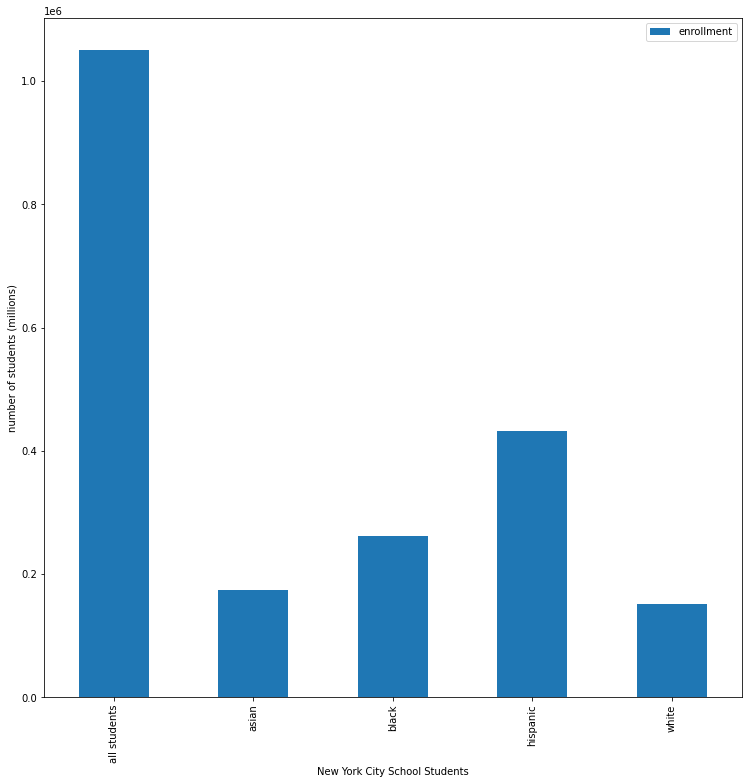

In [7]:
# create a bar chart of new york city student population
# the size is set in inches (don't think it's pixels or else it takes a long time to run)
# to see the full size image, right click and view image


my_dpi=96

ax = city_enroll.plot(x="enroll_cat", y=["enrollment"], kind="bar", figsize=(1200/my_dpi, 1200/my_dpi))

ax.set_xlabel("New York City School Students")

# Set the y-axis label
ax.set_ylabel("number of students (millions)")
pass # pass so only the chartdisplays with no other output

Grouped Bar Chart: student demographics by district
-----------------------------------------------------------------------------
Now we'll make a more complicated bar chart, where we display the
ethnic group populations at the district leve. For this chart
we will have 20 bars (4 groups x 5 boroughs). We use more of the
functions in `matplot` to style our ouput, add titls and legends, etc.

Links:

- [Python Charts: Grouped Bar Charts with Labels in Matplotlib ](https://www.pythoncharts.com/matplotlib/grouped-bar-charts-matplotlib/)
- [Matplotlib: Legend Demo](https://matplotlib.org/stable/gallery/text_labels_and_annotations/legend_demo.html)
- [Seaborn: set_context()](https://seaborn.pydata.org/generated/seaborn.set_context.html)

In [8]:
# now group them by district
boro_enroll = data[["boro", "enroll_cat", "enrollment"]].groupby(["boro", "enroll_cat"], as_index=False).agg(sum)
ui.fmt_table(boro_enroll, num_cols=["enrollment"], col_map={"enroll_cat":"student group"})


,boro,student group,enrollment
0,Bronx,all students,"218,081"
1,Bronx,asian,"11,006"
2,Bronx,black,"58,362"
3,Bronx,hispanic,"136,098"
4,Bronx,white,"8,934"
5,Brooklyn,all students,"315,797"
6,Brooklyn,asian,"53,857"
7,Brooklyn,black,"108,445"
8,Brooklyn,hispanic,"90,867"
9,Brooklyn,white,"54,185"


In [9]:
# create a df for each group we want to plot
asian = boro_enroll.query("enroll_cat == 'asian'")
asian

,boro,enroll_cat,enrollment
1,Bronx,asian,11006
6,Brooklyn,asian,53857
11,Manhattan,asian,20232
16,Queens,asian,80720
21,Staten Island,asian,7943


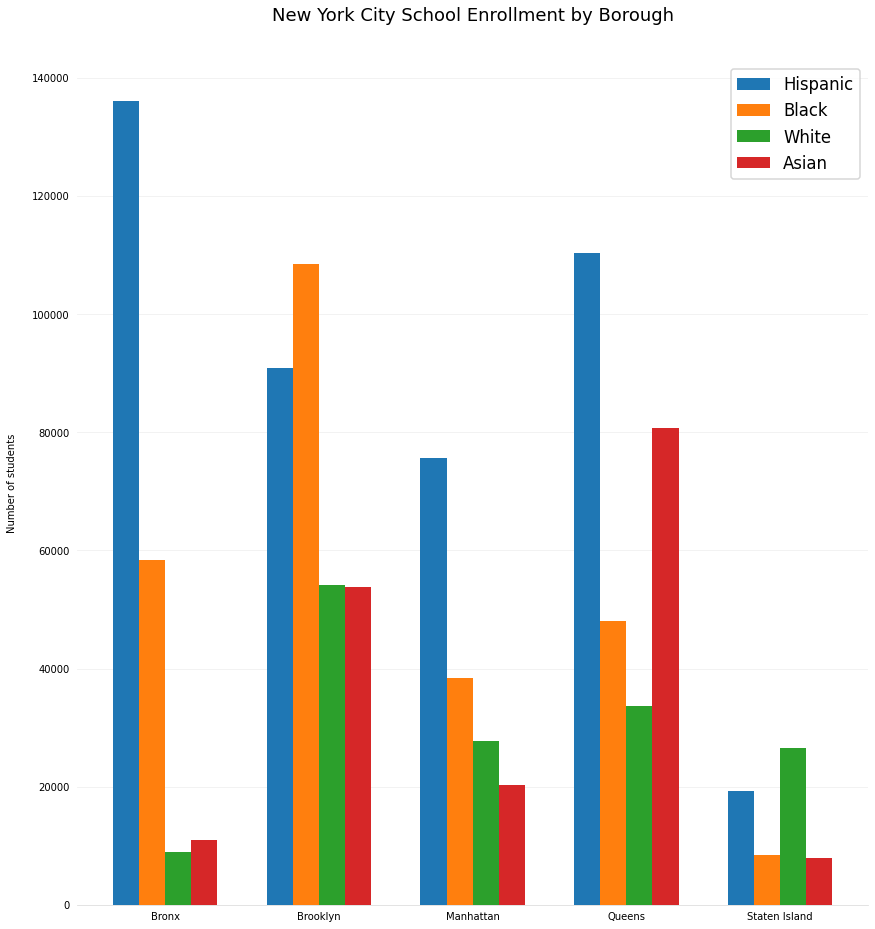

In [10]:
black = boro_enroll.query("enroll_cat == 'black'")
hispanic = boro_enroll.query("enroll_cat == 'hispanic'")
white = boro_enroll.query("enroll_cat == 'white'")

# get the tick marks for the x access
x = np.arange(len(df.boro.unique()))

# instead of plotting the dataframe, get the figure and axis components from the plot
fig, ax = plt.subplots(figsize=(1200/my_dpi, 1200/my_dpi))

# the bar width in inches
w = .17

# add the bars
ax.bar(x + w, hispanic["enrollment"], width=w, label="Hispanic")
ax.bar(x + w * 2, black["enrollment"], width=w, label="Black")
ax.bar(x + w * 3, white["enrollment"], width=w, label="White")
ax.bar(x + w * 4, asian["enrollment"], width=w, label="Asian")

# set the x-ticks to the middle of the bar groups and add labels
ax.set_xticks(x + (w * 5) / 2)
ax.set_xticklabels(boro_enroll.boro.unique())


# style the output
sns.set_context('talk')
# sns.set_context('poster')
# sns.set_context('paper')
# sns.set_context('notebook')

# Set the y-axis label
ax.set_ylabel("Number of students", labelpad=15)

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#efefef')
ax.xaxis.grid(False)


ax.legend()
fig.tight_layout()
ax.set_title('New York City School Enrollment by Borough', pad=40)
pass

Scatter plots and correlations
------------------------------------------
In the next section we're going to see what demographic factors of schools impact
student test scores on the NYS ELA exams, grades 3-8.



In [11]:
factors = ['total_enrollment', 'asian_pct', 'black_pct', 'hispanic_pct', 'white_pct', 'swd_pct', 'ell_pct', 'poverty_pct', 'eni_pct']

# create a table of the correlation matrix with a cool->warm color map
corr = df[factors].corr()
corr.style.background_gradient(cmap='coolwarm')



,total_enrollment,asian_pct,black_pct,hispanic_pct,white_pct,swd_pct,ell_pct,poverty_pct,eni_pct
total_enrollment,1.000000,0.354440,-0.256110,-0.098792,0.188252,-0.190261,-0.002680,-0.159329,-0.200624
asian_pct,0.354440,1.000000,-0.448146,-0.347075,0.196455,-0.211422,0.124392,-0.280980,-0.329161
black_pct,-0.256110,-0.448146,1.000000,-0.432220,-0.453807,0.121400,-0.351531,0.306681,0.249685
hispanic_pct,-0.098792,-0.347075,-0.432220,1.000000,-0.387395,0.067156,0.455705,0.470550,0.540298
white_pct,0.188252,0.196455,-0.453807,-0.387395,1.000000,-0.065563,-0.191012,-0.789705,-0.758151
swd_pct,-0.190261,-0.211422,0.121400,0.067156,-0.065563,1.000000,0.018450,0.187924,0.258617
ell_pct,-0.002680,0.124392,-0.351531,0.455705,-0.191012,0.018450,1.000000,0.342574,0.406880
poverty_pct,-0.159329,-0.280980,0.306681,0.470550,-0.789705,0.187924,0.342574,1.000000,0.911145
eni_pct,-0.200624,-0.329161,0.249685,0.540298,-0.758151,0.258617,0.406880,0.911145,1.000000



**A Pearson's correlation coefficient** was computed to assess the linear relationship 
between _% poverty_ and _% English Language Learners_ (ELL).

There was a positive correlation between the two variables, r(9167) = 0.34, p = 0.000.


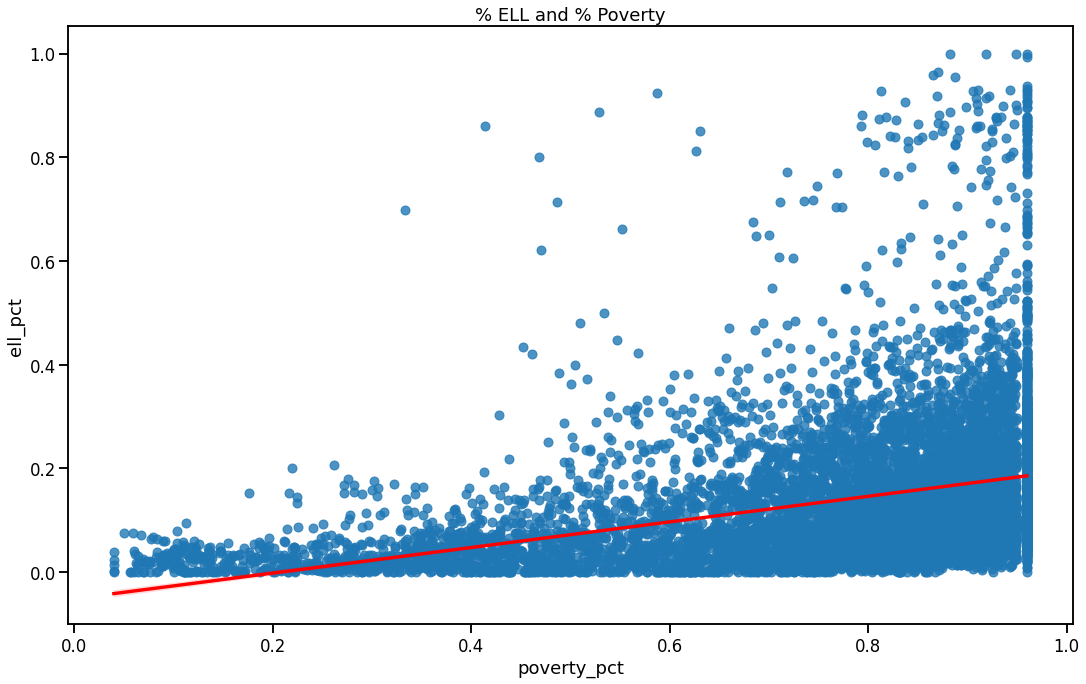

In [12]:
# use seaborn to create a scatter plot with a linear regression fit line between pct poverty and pct ELL students

g = sns.regplot(x=df["poverty_pct"], y=df["ell_pct"], line_kws={"color": "red"} )
g.figure.set_size_inches(18, 11)
g.set(title="% ELL and % Poverty")

r = pg.corr(df["poverty_pct"], df["ell_pct"])
degs_f = r.n[0] - 2

report_r = f"""
**A Pearson's correlation coefficient** was computed to assess the linear relationship 
between _% poverty_ and _% English Language Learners_ (ELL).

There was a positive correlation between the two variables, r({degs_f}) = {r['r'][0]:.2f}, p = {r['p-val'][0]:.3f}.
"""

md(report_r)


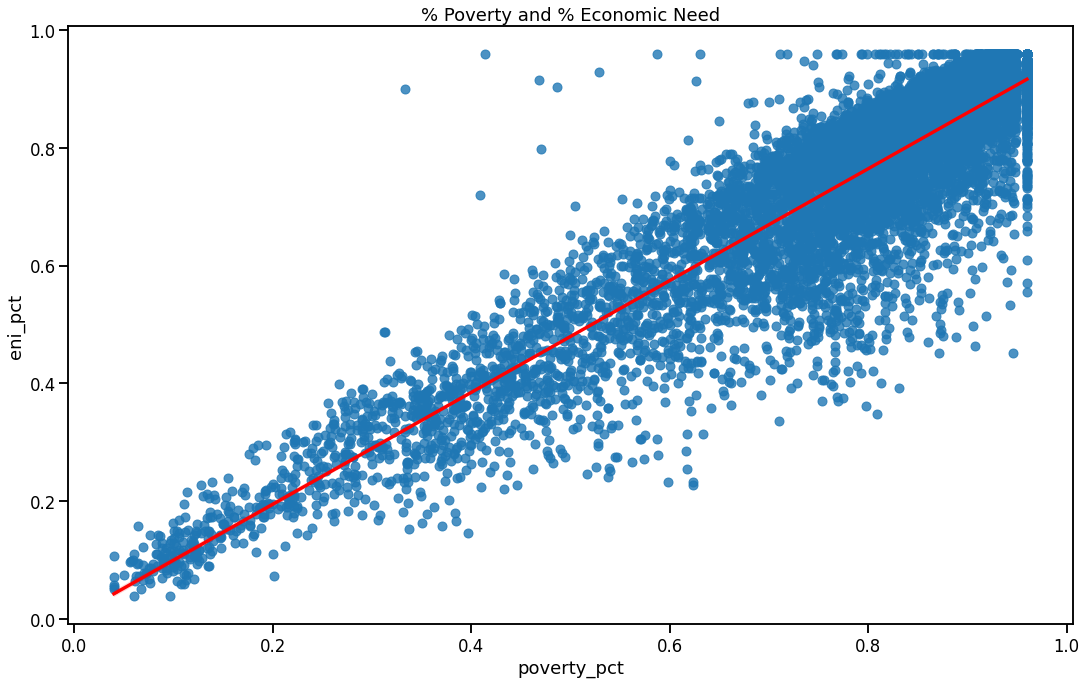

In [13]:
# plot highly correlated % poverty and economic need index -- both measures look at poverty in schools
g = sns.regplot(x=df["poverty_pct"], y=df["eni_pct"], line_kws={"color": "red"} )
g.figure.set_size_inches(18, 11)

g.set(title="% Poverty and % Economic Need")

pass


### Drop outliers

For the next correlation, first we'll drop the outliers by computing z-scores. Outliers can distort the results of our correlations.


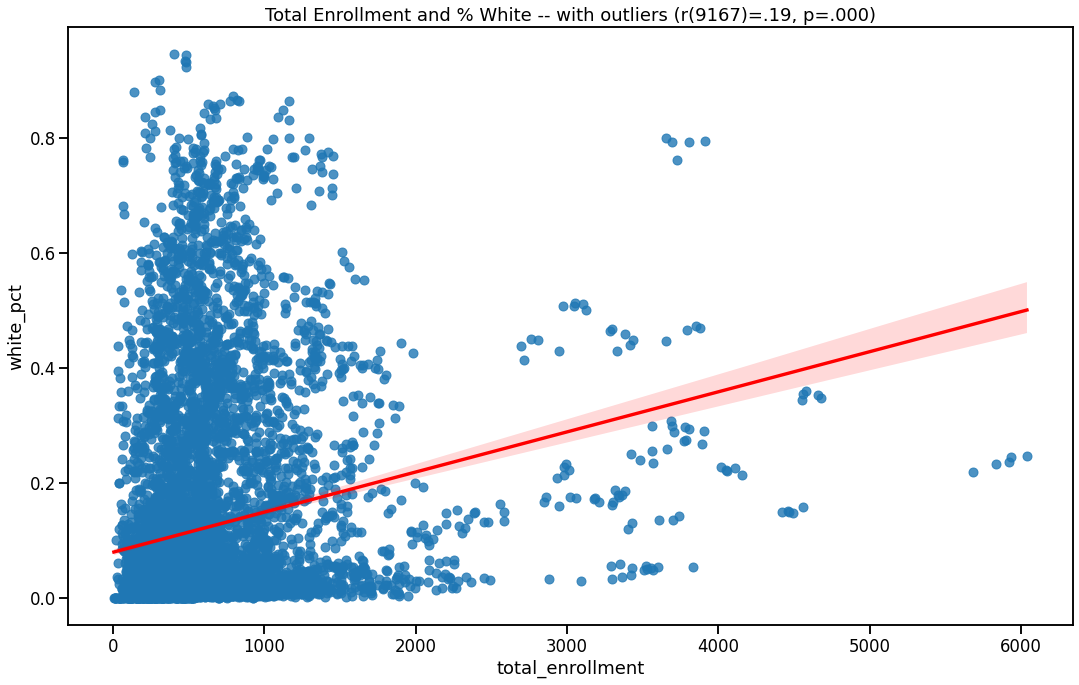

In [14]:
outliers = df[["white_pct", "total_enrollment"]]
x = outliers["total_enrollment"]
y = outliers["white_pct"]
g = sns.regplot(x=x, y=y, line_kws={"color": "red"})
g.figure.set_size_inches(18, 11)
r = pg.corr(x, y)
# use the ui helper funciont fmt_pearson to report the r and p values from our correlation
g.set(title=f"Total Enrollment and % White -- with outliers ({ui.fmt_pearson(r)})")
pass

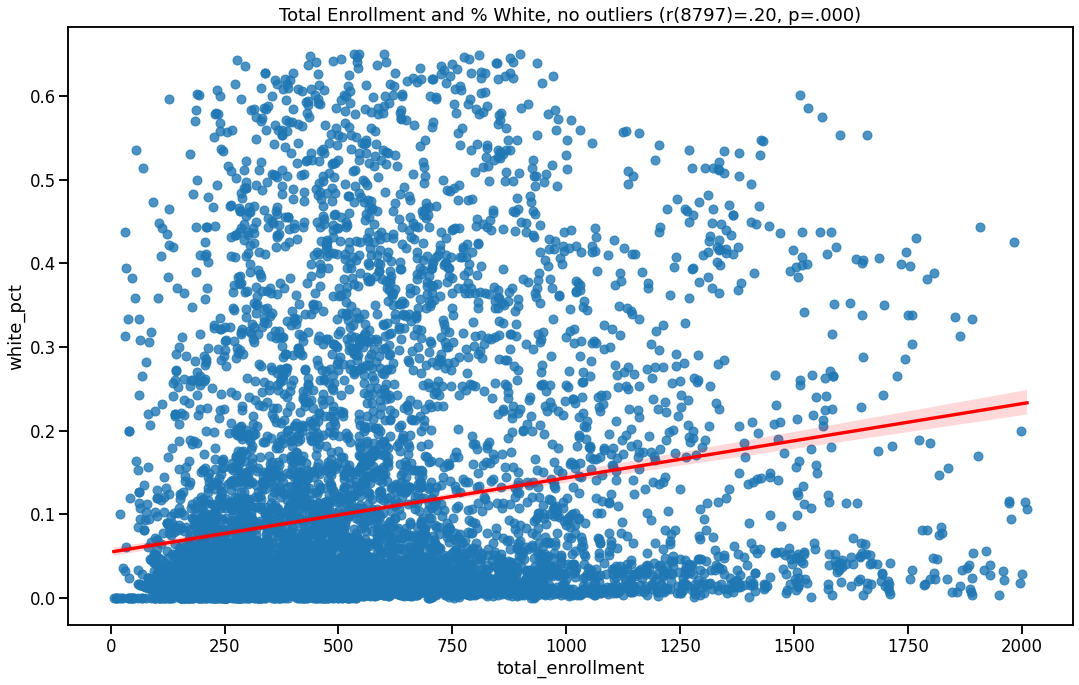

In [15]:
no_outliers = df[["white_pct", "total_enrollment"]]

# drop outliers greater than 2 standard deviations
no_outliers = no_outliers[(np.abs(scipy.stats.zscore(no_outliers)) < 3).all(axis=1)]

x = no_outliers["total_enrollment"]
y = no_outliers["white_pct"]

r = pg.corr(x, y)

g = sns.regplot(x=x, y=y, line_kws={"color": "red"})
g.figure.set_size_inches(18, 11)


g.set(title=f"Total Enrollment and % White, no outliers ({ui.fmt_pearson(r)})")
pass

Network Graph Diagram
-----------------------------------

In this section we create a network graph diagram to help visualize
the factors in an Ordinary Least Squares (OLS) regression that
analyzes the effect of school demographics on ELA test scores.

In [16]:
# use the ela data frame that we loaded at the top

# get just the 2019 test results for All Students
# this will be the dependent variable in our regression
ela = ela.query("year == 2019 and category == 'All Students'")
ela

,dbn,district,boro,school_name,year,total_enrollment,grade_3k_pk_half_day_full,grade_k,grade_1,grade_2,...,level_1,level_1_pct,level_2,level_2_pct,level_3,level_3_pct,level_4,level_4_pct,level_3_4,level_3_4_pct
81,01M015,1,Manhattan,P.S. 015 Roberto Clemente,2019,190,14,29,28,38,...,1.0,3.703704,7.0,25.925926,18.0,66.666664,1.0,3.703704,19.0,70.370369
82,01M015,1,Manhattan,P.S. 015 Roberto Clemente,2019,190,14,29,28,38,...,0.0,0.000000,4.0,22.222221,11.0,61.111111,3.0,16.666666,14.0,77.777779
83,01M015,1,Manhattan,P.S. 015 Roberto Clemente,2019,190,14,29,28,38,...,6.0,24.000000,10.0,40.000000,4.0,16.000000,5.0,20.000000,9.0,36.000000
84,01M015,1,Manhattan,P.S. 015 Roberto Clemente,2019,190,14,29,28,38,...,7.0,10.000000,21.0,30.000000,33.0,47.142857,9.0,12.857142,42.0,60.000000
205,01M019,1,Manhattan,P.S. 019 Asher Levy,2019,236,16,25,27,39,...,0.0,0.000000,8.0,33.333332,15.0,62.500000,1.0,4.166667,16.0,66.666664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200192,32K554,32,Brooklyn,All City Leadership Secondary School,2019,433,0,0,0,0,...,4.0,2.312139,11.0,6.358381,45.0,26.011560,113.0,65.317917,158.0,91.329483
200368,32K562,32,Brooklyn,Evergreen Middle School for Urban Exploration,2019,380,0,0,0,0,...,55.0,52.380951,22.0,20.952381,19.0,18.095238,9.0,8.571428,28.0,26.666666
200369,32K562,32,Brooklyn,Evergreen Middle School for Urban Exploration,2019,380,0,0,0,0,...,42.0,38.532108,35.0,32.110092,26.0,23.853210,6.0,5.504587,32.0,29.357798
200370,32K562,32,Brooklyn,Evergreen Middle School for Urban Exploration,2019,380,0,0,0,0,...,16.0,14.678899,57.0,52.293579,28.0,25.688074,8.0,7.339449,36.0,33.027523


In [17]:
# calculate coefficients for these factors
factors = ['total_enrollment', 'asian_pct',  'black_pct', 
       'hispanic_pct',  'white_pct','swd_pct',  'ell_pct',  'poverty_pct']

# y is the DV
y = ela['mean_scale_score']

X = ela[factors]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       mean_scale_score   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     1364.
Date:                Tue, 05 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:53:40   Log-Likelihood:                -15120.
No. Observations:                4826   AIC:                         3.026e+04
Df Residuals:                    4817   BIC:                         3.032e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              617.3477      2.828    218.313      0.000     611.804     622.891
total_enrollment    -0.0004      0.000     -1.247      0.213      -0.001       0.000
asian_pct           19.0515      3.212      5.931      0.000      12.754      25.349
black_pct           -0.5863      3.169     -0.185      0.853      -6.799       5.627
hispanic_pct         6.5543      3.144      2.085      0.037       0.391      12.718
white_pct            7.8966      3.066      2.575      0.010       1.886      13.907
swd_pct            -30.5943      1.514    -20.213      0.000     -33.562     -27.627
ell_pct            -27.1083      1.027    -26.404      0.000     -29.121     -25.096
poverty_pct        -17.9743      0.841    -21.384      0.000     -19.622     -16.326
==============================================================================
Omnibus:                      278.793   Durbin-Watson:                   0.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              522.809
Skew:                           0.426   Prob(JB):                    2.98e-114
Kurtosis:                       4.369   Cond. No.                     5.86e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
# pull out the coefficient values from the model -- this is the data we're going to graph
coeff = model.conf_int()
pd.DataFrame({"parameters": list(coeff.index), "coefficient":model.params})

graph_data = pd.DataFrame({
    'parameter': model.params.index.values[1:],
    'coef': model.params.values[1:],
    'pvalue': model.pvalues.round(4).values[1:]
})

# add some columns to that contains the data for the graph attributes

graph_data["color"] = graph_data.coef.apply(lambda x: "blue" if x > 0 else "red")


graph_data["effect_size"] = graph_data.coef.apply(lambda x: abs(x))
graph_data["target"] = "mean_scale_score"


# the biggest circle size for a node, in pixels
max_node_size = 1800
max_edge_size = 20
# the largest abs coef -- this will be our biggest node (i.e. 400px)
max_weight = graph_data.effect_size.max()


# each other node will be a smaller percent of the largest one, store as `area`
graph_data["node_size"] = graph_data.effect_size.apply(lambda x: math.ceil(max_node_size * (x/max_weight) ))
# graph_data["weight"] = graph_data.effect_size.apply(lambda x: math.log(max_edge_size * (x/max_weight) ))



# set the node labels and edge labels
graph_data["node_label"] = graph_data.apply(lambda row: f"{row.parameter}\n(p={row.pvalue:.3f})", axis=1)

# add a row to our graph for the DV
dv = dv = {
  'parameter': "mean_scale_score",
  'coef': 1,
  'pvalue': 0,
  'color': "green",
  'effect_size': 1,
  'target': "mean_scale_score",
  'node_size': max_node_size * 2,
  'weight': max_edge_size * 2,
  'node_label': "mean_scale_score"
}
# append a row at the end of our df
graph_data.loc[len(graph_data)+1] = dv

graph_data["edge_label"] = graph_data["coef"].apply(lambda x:f"{x:.2f}")


graph_data

,parameter,coef,pvalue,color,effect_size,target,node_size,node_label,edge_label
0,total_enrollment,-0.000359,0.2126,red,0.000359,mean_scale_score,1,total_enrollment\n(p=0.213),-0.00
1,asian_pct,19.051511,0.0000,blue,19.051511,mean_scale_score,1121,asian_pct\n(p=0.000),19.05
2,black_pct,-0.586311,0.8532,red,0.586311,mean_scale_score,35,black_pct\n(p=0.853),-0.59
3,hispanic_pct,6.554337,0.0371,blue,6.554337,mean_scale_score,386,hispanic_pct\n(p=0.037),6.55
4,white_pct,7.896592,0.0100,blue,7.896592,mean_scale_score,465,white_pct\n(p=0.010),7.90
5,swd_pct,-30.594307,0.0000,red,30.594307,mean_scale_score,1800,swd_pct\n(p=0.000),-30.59
6,ell_pct,-27.108250,0.0000,red,27.108250,mean_scale_score,1595,ell_pct\n(p=0.000),-27.11
7,poverty_pct,-17.974344,0.0000,red,17.974344,mean_scale_score,1058,poverty_pct\n(p=0.000),-17.97
9,mean_scale_score,1.000000,0.0000,green,1.000000,mean_scale_score,3600,mean_scale_score,1.00


{('total_enrollment', 'mean_scale_score'): '-0.00', ('mean_scale_score', 'asian_pct'): '19.05', ('mean_scale_score', 'black_pct'): '-0.59', ('mean_scale_score', 'hispanic_pct'): '6.55', ('mean_scale_score', 'white_pct'): '7.90', ('mean_scale_score', 'swd_pct'): '-30.59', ('mean_scale_score', 'ell_pct'): '-27.11', ('mean_scale_score', 'poverty_pct'): '-17.97'}


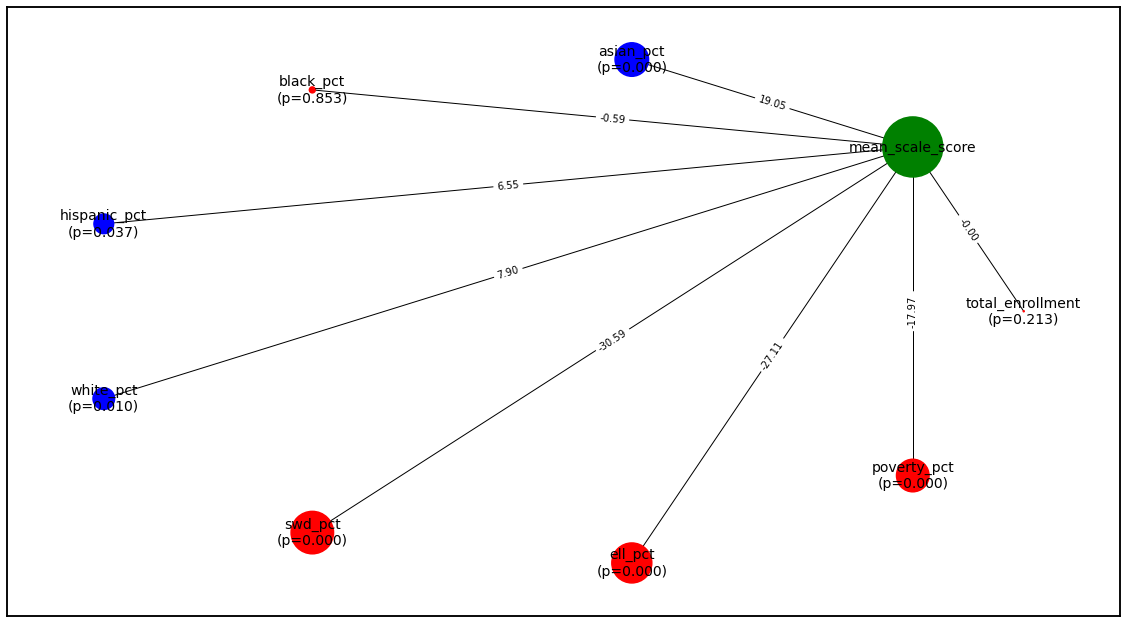

In [19]:
# create the graph and plot objects
G = nx.from_pandas_edgelist(
    graph_data,
    source="parameter",
    edge_attr=["color", "edge_label"],
)
fig, ax = plt.subplots(figsize=(16,9))
pos = nx.circular_layout(G)


# label the nodes with the parameter name and p-value
labels = dict(zip(graph_data.parameter,graph_data.node_label))


# don't create an edge for the dependent variable to itself
G.remove_edge("mean_scale_score", "mean_scale_score")


# look these up to make sure they match the same order as the nodes
colors = []
node_size = []
for n in G.nodes():
    row = graph_data[graph_data.parameter == n]  
    colors.append(row.color.values[0])
    node_size.append(row.node_size.values[0])
      
edge_labels = nx.get_edge_attributes(G, "edge_label")
print(edge_labels)

nx.draw_networkx_nodes(G, pos, ax = ax, node_color=colors, node_size=node_size)
nx.draw_networkx_edges(G, pos, ax=ax)
nx.draw_networkx_edge_labels(G,pos, ax=ax, edge_labels=edge_labels, label_pos=.5, font_size=10)
nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=14)



# to make sure our labels don't get clipped

plt.tight_layout()
plt.margins(0.05)
